## Detecting Objects (bubble) and measure their properties

The first algorithm uses the contour function. Contours are lines with the same intensity level.

In [1]:
#libraries for image processing
from skimage import measure
from skimage.draw import circle_perimeter_aa
from skimage.color import rgb2gray
#libraries for plotting
import matplotlib.pyplot as plt
#libraries for matrix algebra
import numpy as np
#libraries for loading and storing images/movies
import imageio
#libraries for analyzing polygons
from shapely.geometry import Polygon

#image range
N = 102
N_start = 0

#threshold for detecting an object
my_thresh = 90

#crop range
x1,x2= 50,250
y1,y2= 120,250

#file to analyse are listed here 
experiment_video='Camera1_15_00_13_BigBub_Hydrophone1mm_500k_7V.AVI'
label='Gel. 8% near hyd.'

fr=2. #frame interval time in microseconds
scale=1e-5 #size of one pixel in m

#read images from the movies into a numpy array simplifies things if video is not too long
mo = imageio.mimread(experiment_video)

mov = np.asarray(([rgb2gray(mo[nn]) for nn in range(len(mo))]))*256

#crop image
mov = mov[:,y1:y2,x1:x2]

mov2=np.copy(mov)

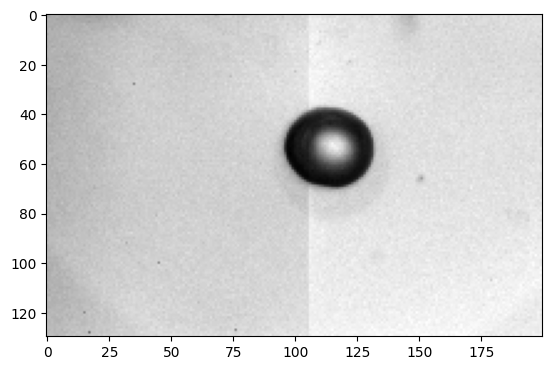

In [2]:
plt.imshow(mov2[10,:,:],cmap='gray');

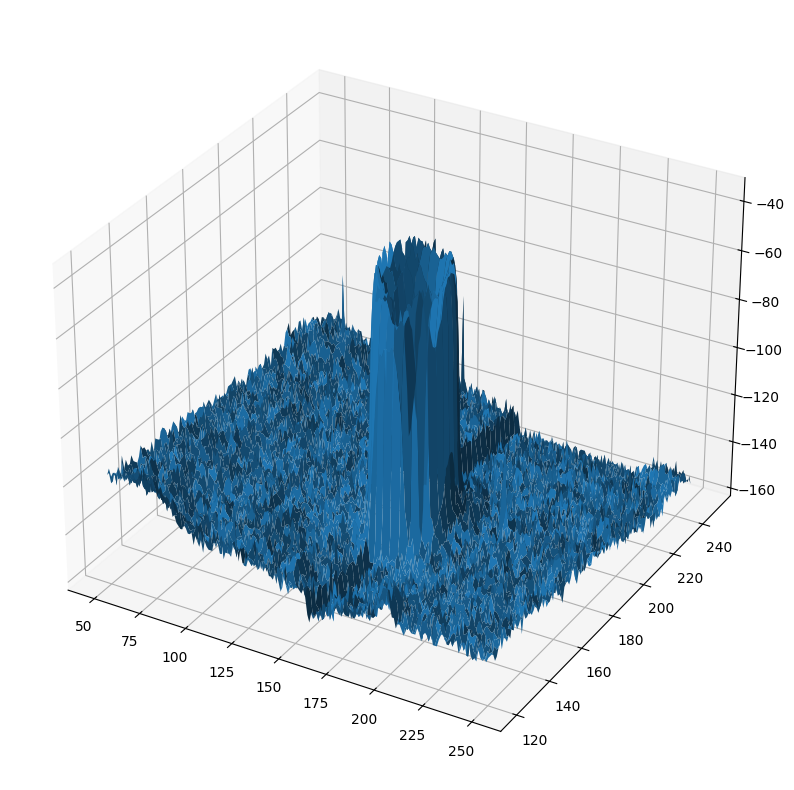

In [3]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(np.linspace(x1,x2,x2-x1), np.linspace(y1,y2,y2-y1))
ax.plot_surface(X,Y,-mov2[10,:,:]);

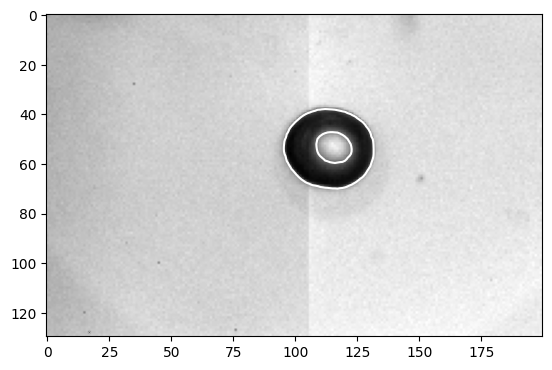

In [4]:
plt.imshow(mov2[10,:,:],cmap='gray')
plt.contour(mov2[10,:,:],[my_thresh],colors='w');

In [5]:
cont=measure.find_contours(mov2[10,:,:], my_thresh)
l=np.asarray([len(cont[nn]) for nn in range(len(cont))])
l

array([137,  53,   5])

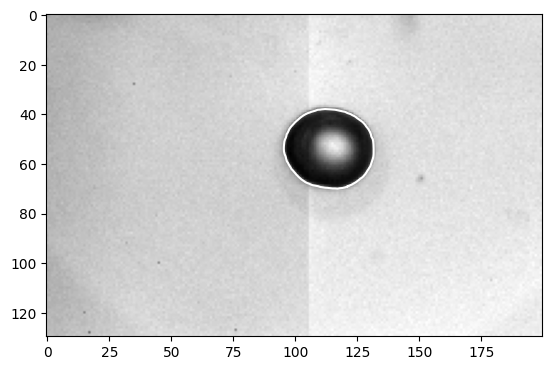

In [6]:
plt.imshow(mov2[10,:,:],cmap='gray')
plt.plot(cont[0][:,1],cont[0][:,0],'w');

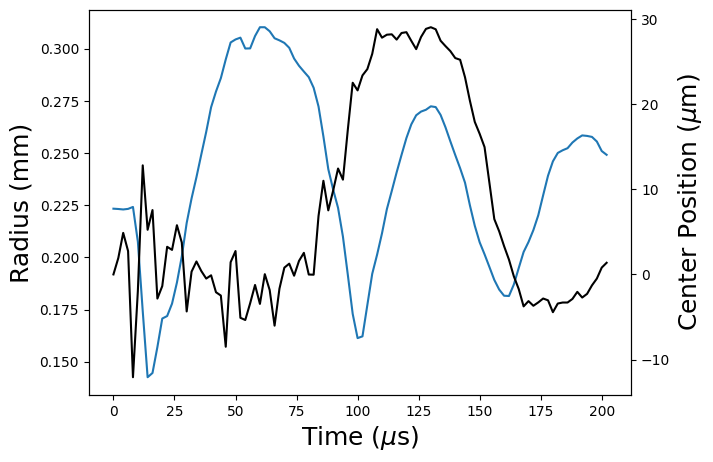

In [7]:
#list of contours for the detected bubbles
kl=list()

for i in range(N_start,N):

    #select one image
    img = mov[i]
    
    # calculate contour with a fixed threshold
    cont=measure.find_contours(img, my_thresh)
    
    # find the longest contour, this is likely the biggest bubble
    l=np.asarray([len(cont[nn]) for nn in range(len(cont))])
    y=cont[l.argmax()][:,0]
    x=cont[l.argmax()][:,1]
    
    # store contour as polygon
    k=Polygon(np.asarray([x,y]).T);
    
    # save polygon
    kl.append(k)
    
    # add circle on top of images for later verification
    rr, cc, val=circle_perimeter_aa(int(k.centroid.y), int(k.centroid.x),\
                                    int(np.sqrt(k.area/np.pi)))
    mov[i, rr, cc] = val * 255

        
#generate time and radius data
t_data=np.linspace(0,N-N_start-1,N-N_start)*fr*1e-6
R_data=(np.asarray([kl[nn].area for nn in range(len(kl))])/np.pi)**.5*scale

#calculate displacement of centroid 
centroids=[kl[nn].centroid for nn in range(len(kl))]
dist=np.asarray([centroids[0].y-centroids[nn].y for nn in range(len(centroids))])*1e-5

#start the plotting
plt.figure(figsize=(7,5),dpi=100)
ax1=plt.gca()
#plot radius and position
ax1.plot(t_data*1e6,R_data*1e3)
ax2 = ax1.twinx() 
ax2.plot(t_data*1e6,dist*1e6,'k')
ax1.set_ylabel('Radius (mm)',fontsize=18)
ax1.set_xlabel(r'Time ($\mu$s)',fontsize=18)
ax2.set_ylabel(r'Center Position ($\mu$m)',fontsize=18);

<>:82: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
/var/folders/s3/p9ykkz492470386n1wfgtlbw0000gn/T/ipykernel_78792/2383301622.py:82: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_xlabel('time ($\mu$s)',fontsize=15)


(-10.0, 200.0)

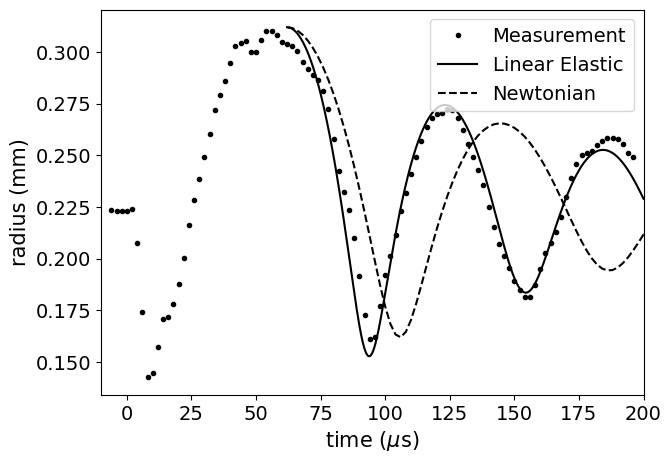

In [11]:
%matplotlib inline 

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
from scipy.optimize import minimize
import numpy as np #work with arrays

 
dydt=np.zeros(2) #global array variable

p0=1e5            # ambient pressure
rho=1e3           # density of the liquid
R0=R_data[0]
nu0=2.3e-4           # Viscosity in m^2/s
nu=nu0
c=1.5e3
pv=0.             # vapour pressure
sigma=0.072       # Surface tension N/m
kappa=1.0
eta0=5.8e4           # Elasticity parameter
eta=eta0
nu=nu0

alpha=1.          # parameter for Fung
eta_kind=3

t_final = 200e-6
Rmax=312e-6
t0=62e-6

#E(eta,alpha,R0,y[0],Rmax)
#  a   b    c  d    e 

E=lambda a,b,c,d,e : 0.                      #Newtonian
        
if (eta_kind == 1):                          #Neo-Hookean
    E=lambda a,b,c,d,e : a/2.*(5.-4.*(c/d)-(c/d)**4.) 
if (eta_kind == 2):                          #Yang & Church
    E=lambda a,b,c,d,e : 4.*a/3.*(1-(c/d)**3.)            
if (eta_kind == 3):                          #Linear elastic
    E=lambda a,b,c,d,e : 2.*a*(1-(c/d)**2.)               
if (eta_kind == 4):                          #Fung et al.
    E=lambda a,b,c,d,e : -2.*a*integrate.quad(lambda x: (x**-5+x**-2)*np.exp(b*(x**-4+2.*x**2-3.)), d/e, 1.)[0]



#Rayleigh Plesset Equation
def rp(y,t):
    pa=0.
    pinfty = p0+pa
    pg0 = p0+2.*sigma/R0-pv
    dydt0 = y[1] 
    dydt1 = (pv-pinfty+pg0*(R0/y[0])**(3.*kappa)\
            -2.*sigma/y[0])/rho/y[0]-1.5*y[1]**2./y[0]\
            -4.*nu*y[1]/y[0]/y[0]-E(eta,alpha,R0,y[0],R0)/rho/y[0]
    return [dydt0,dydt1]


#tosc=0.914*Rmax*np.sqrt(rho/p0)    #estimated from the Rayleigh collapse time

t = np.linspace(t0, t_final, 10000)
t_pdata=t_data[31:]
R_pdata=R_data[31:]


sol=odeint(rp, [Rmax,0.], t)
R1=sol[:, 0]

E=lambda a,b,c,d,e : 0. 

sol=odeint(rp, [Rmax,0.], t)
Rorg=sol[:, 0]
Rorgint=np.interp(t_pdata,t,Rorg)

plt.figure(figsize=(7,5),dpi=100)
ax1=plt.gca()
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=13)
ax1.plot(t_data*1e6-6.,R_data*1e3,'k.',t*1e6,R1*1e3,'k-', t_pdata*1e6,Rorgint*1e3,'k--')
ax1.legend(('Measurement','Linear Elastic','Newtonian'),fontsize=14,loc='upper right')
ax1.set_xlabel('time ($\mu$s)',fontsize=15)
ax1.set_ylabel('radius (mm)',fontsize=15)
ax1.set_xlim((-10,200))

